In [1]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import cv2
import os

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# DIR_PATH = '/content/drive/MyDrive/COVID-19 Radiography Database/'

DIR_PATH = '../COVID-19 Radiography Database/'
CLASSES = ['NORMAL', 'Viral Pneumonia', 'COVID']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Load dataset

In [ ]:
img_height = 150
img_width = 150

all_data = []
for dirname, _, filenames in os.walk(DIR_PATH):
    for file in filenames:
        if 'png' in file:
            image = cv2.imread(os.path.join(dirname, file))
            image = cv2.resize(image, (img_height, img_width))
            label = os.path.split(dirname)[-1]
            all_data.append([image, label])

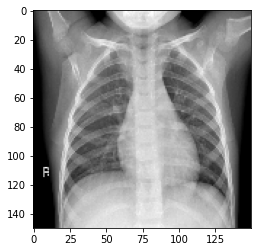

NORMAL


In [ ]:
plt.imshow(all_data[100][0])
plt.show()
print(all_data[100][1])

In [ ]:
X = []
Y = []
for img, lbl in all_data:
    X.append(img)
    Y.append(lbl)
X = np.array(X)
Y = np.array(Y)

In [ ]:
# np.save('/content/drive/MyDrive/X_file', X)
# np.save('/content/drive/MyDrive/y_file', Y)

In [3]:
# X = np.load('/content/drive/MyDrive/X_file.npy')
# Y = np.load('/content/drive/MyDrive/y_file.npy')

## 2. Split data into train, validation and test sets and explore

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_check, Y_train, Y_check = train_test_split(X, Y, test_size=0.2)
X_test, X_val, Y_test, Y_val = train_test_split(X_check, Y_check, test_size=0.5)

print("\nTrain set")
print("Images: ",X_train.shape)
print("Labels shape: ",Y_train.shape)
print("\nValidation set")
print("Images: ",X_val.shape)
print("Labels shape: ",Y_val.shape)
print("\nTest set")
print("Images: ",X_test.shape)
print("Labels shape: ",Y_test.shape)


Train set
Images:  (3108, 150, 150, 3)
Labels shape:  (3108,)

Validation set
Images:  (389, 150, 150, 3)
Labels shape:  (389,)

Test set
Images:  (389, 150, 150, 3)
Labels shape:  (389,)


In [5]:
img_height = 150
img_width = 150

print(X_train.min(),X_train.max(),X_train.mean(),X_train.std())
print(X_val.min(),X_val.max(),X_val.mean(),X_val.std())

0 255 129.14981813241812 60.94757639326039
0 255 129.18267169380178 61.379420498249715


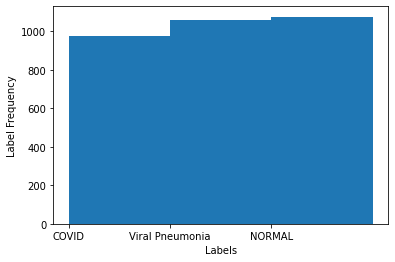

In [ ]:
plt.figure()
plt.hist(Y_train, bins = range(4))
plt.xlabel("Labels")
plt.ylabel("Label Frequency")
plt.show()

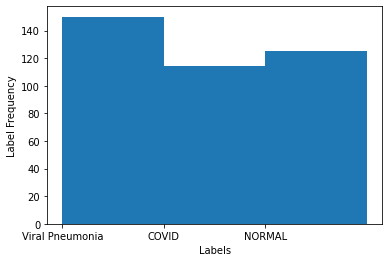

In [ ]:
plt.figure()
plt.hist(Y_test, bins = range(4))
plt.xlabel("Labels")
plt.ylabel("Label Frequency")
plt.show()

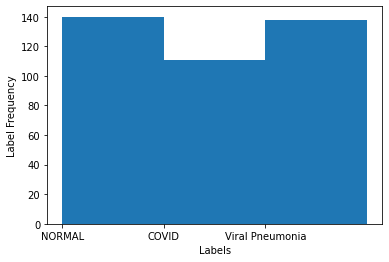

In [ ]:
plt.figure()
plt.hist(Y_val, bins = range(4))
plt.xlabel("Labels")
plt.ylabel("Label Frequency")
plt.show()

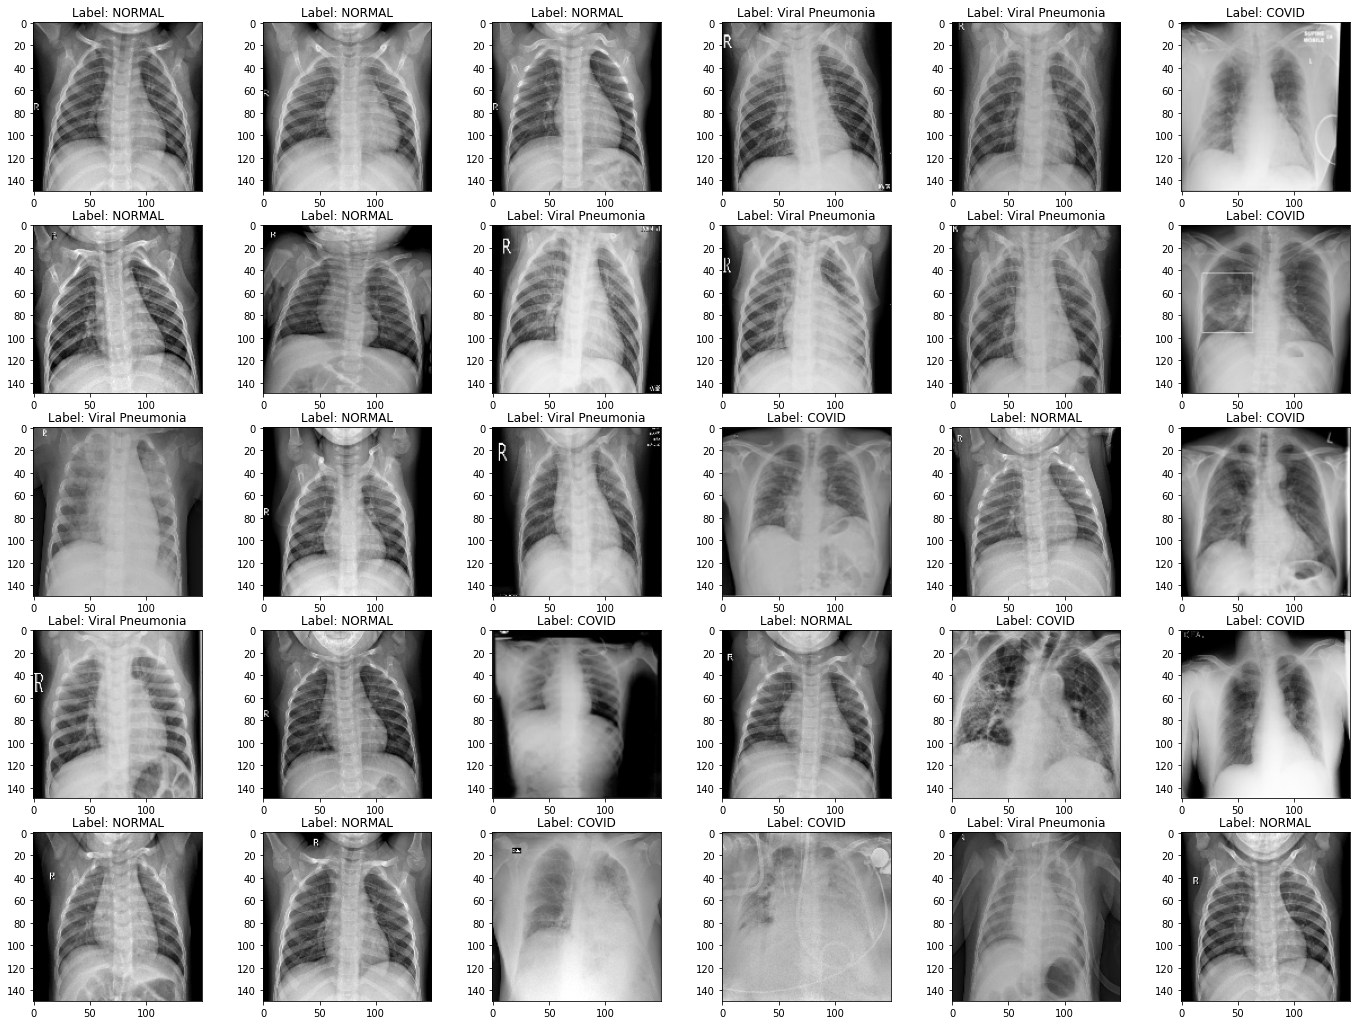

In [ ]:
# Displaying some samples from the development set
sample_indexes = np.random.choice(np.arange(X_train.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_train[jj], cmap = "gray")
    plt.title("Label: %s" %Y_train[jj])
plt.show()

## 3. One hot encoding

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
Y_train_enc = le.fit_transform(Y_train)
Y_val_enc = le.transform(Y_val)
Y_test_enc = le.transform(Y_test)

Y_train_oh = tf.keras.utils.to_categorical(Y_train_enc)
Y_val_oh = tf.keras.utils.to_categorical(Y_val_enc)
Y_test_oh = tf.keras.utils.to_categorical(Y_test_enc)

print("Labels:")
print(Y_train[:5])
print()
print("One hot encoded labels:")
print(Y_train_oh[:5])

Labels:
['COVID' 'NORMAL' 'NORMAL' 'NORMAL' 'NORMAL']

One hot encoded labels:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


## 4. Data scaling and Data Augmentation

In [7]:
# Experiment with different data scaling methods
norm_type = 1 # 0 -> min-max; 1-> standardization

if norm_type == 0:
    X_train = X_train/255
    X_val = X_val/255
    X_test = X_test/255
elif norm_type == 1:
    train_mean, train_std = X_train.mean(),X_train.std() 
    X_train = (X_train - train_mean)/train_std
    X_val = (X_val - train_mean)/train_std
    X_test = (X_test - train_mean)/train_std
else:
    pass
# Create your data augmentation object to improve training
# set your batch size

batch_size = 32
gen_params = {"featurewise_center":False,"samplewise_center":False,"featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,"zca_whitening":False,"rotation_range":20,"width_shift_range":0.1,"height_shift_range":0.1,\
              "shear_range":0.2, "zoom_range":0.1,"horizontal_flip":True,"fill_mode":'constant',\
               "cval": 0}
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(gen_params)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(gen_params)

train_gen.fit(X_train,seed = 1)
val_gen.fit(X_val, seed = 1)

train_flow = train_gen.flow(X_train,Y_train_oh,batch_size = batch_size)
val_flow = val_gen.flow(X_val,Y_val_oh,batch_size = batch_size) 

## 5. Define your callbacks (save your model, patience, etc.)

In [ ]:
model_name = "cnn.h5"
early_stop_cnn = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [ ]:
model_name_vgg16 = "vgg16_cnn.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)

monitor_vgg16 = tf.keras.callbacks.ModelCheckpoint(model_name_vgg16, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [9]:
model_name_resnet50 = "resnet50_cnn.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)

monitor_resnet50 = tf.keras.callbacks.ModelCheckpoint(model_name_resnet50, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## SVM Model

In [11]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, svd_solver='randomized', whiten=True, random_state=32)
svc = SVC(kernel='rbf', class_weight='balanced', probability=True)
SVC_model = make_pipeline(pca, svc)

In [12]:
X_train_flat = np.reshape(X_train,(3108, 67500))
X_test_flat = np.reshape(X_test,(389, 67500))
print(X_train_flat.shape)
print(X_test_flat.shape)

(3108, 67500)
(389, 67500)


In [14]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [15, 25, 35],
              'svc__gamma': [0.004, 0.005, 0.006]}
grid = GridSearchCV(SVC_model, param_grid)

%time grid.fit(X_train_flat, Y_train)
print(grid.best_params_)

CPU times: user 51min 43s, sys: 3min 42s, total: 55min 25s
Wall time: 32min 2s
{'svc__C': 15, 'svc__gamma': 0.006}


In [15]:
X_test_flat = np.reshape(X_test,(389, 67500))
SVC_model = grid.best_estimator_
yfit = SVC_model.predict(X_test_flat)

In [16]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, yfit,
                            target_names=CLASSES))

                 precision    recall  f1-score   support

         NORMAL       0.98      0.98      0.98       124
Viral Pneumonia       0.97      0.95      0.96       126
          COVID       0.95      0.96      0.95       139

       accuracy                           0.96       389
      macro avg       0.96      0.96      0.96       389
   weighted avg       0.96      0.96      0.96       389



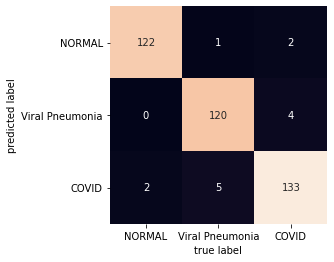

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(Y_test, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=CLASSES,
            yticklabels=CLASSES)
plt.xlabel('true label')
plt.ylabel('predicted label');

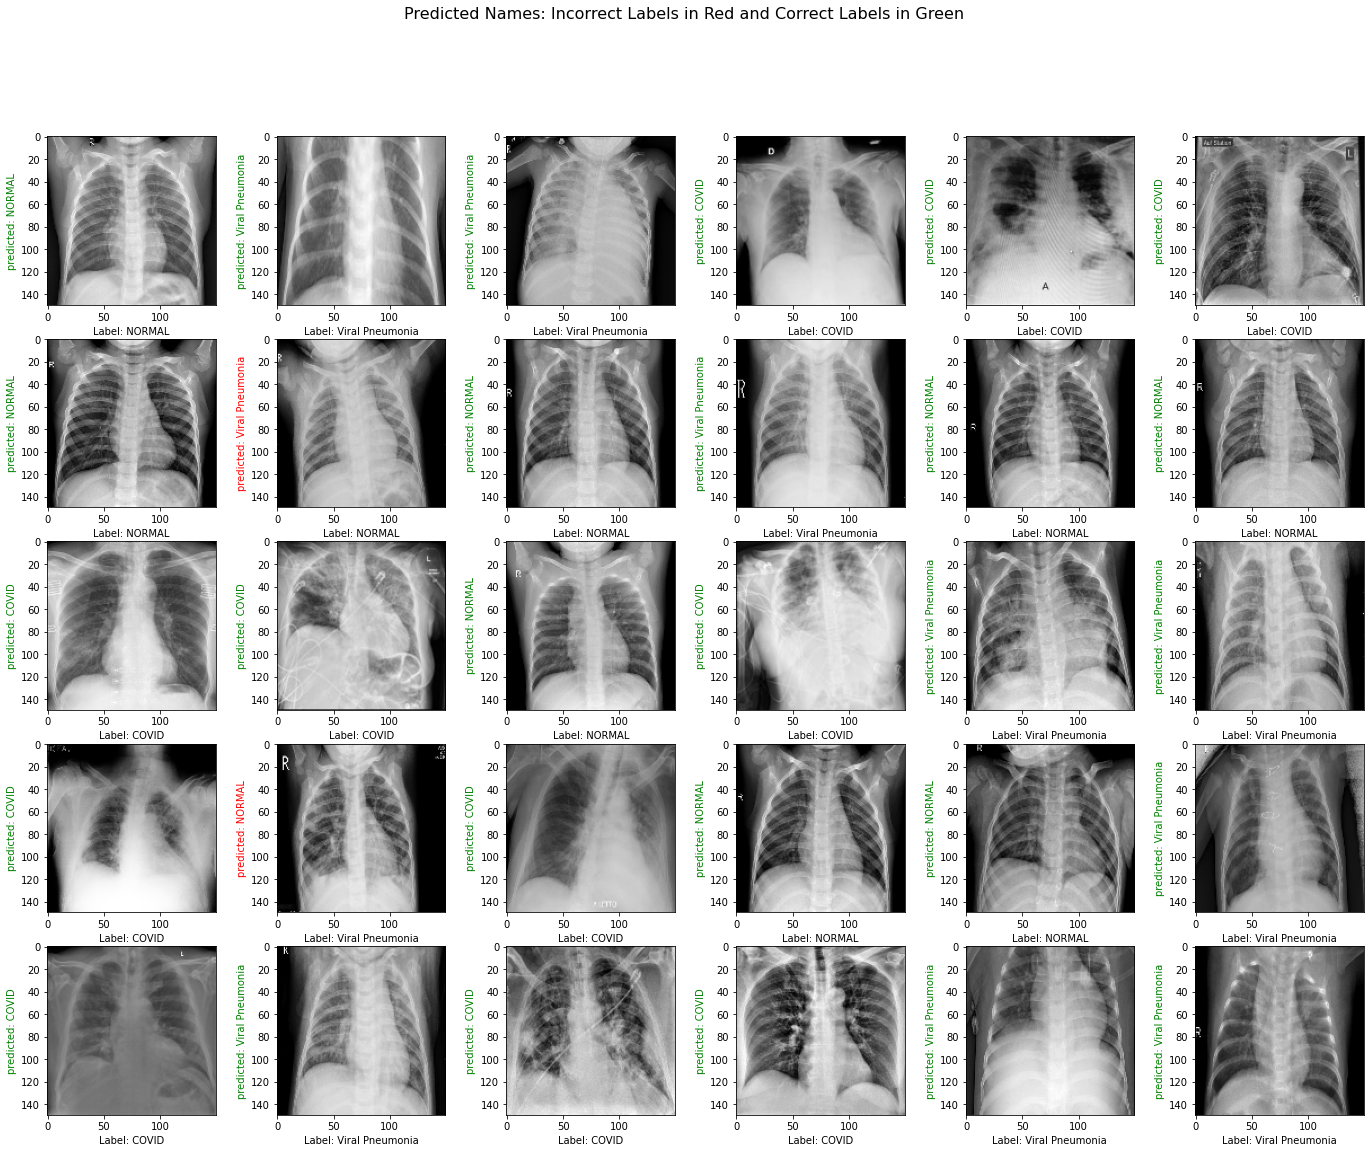

In [18]:
sample_indexes = np.random.choice(np.arange(X_test.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    aux = X_test[jj]
    aux = (aux - aux.min())/(aux.max() - aux.min())
    plt.imshow(aux, cmap = "gray")
    plt.xlabel("Label: %s" %(Y_test[jj]))
    plt.ylabel("predicted: %s"%(yfit[jj]),
                   color='green' if yfit[jj] == Y_test[jj] else 'red')
plt.suptitle('Predicted Names: Incorrect Labels in Red and Correct Labels in Green', size=16)
plt.show()

roc_auc score of labels 0, 1, 2 is  {0: 0.9958916615946439, 1: 0.9950509988532802, 2: 0.993410071942446}


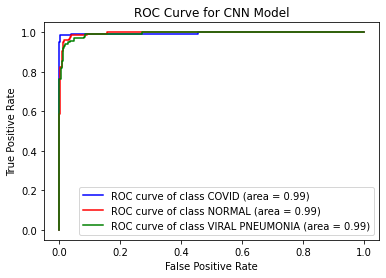

In [19]:
from sklearn.metrics import roc_auc_score, auc, roc_curve

Ypred_proba = SVC_model.predict_proba(X_test_flat)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
  fpr[i], tpr[i], thres = roc_curve(Y_test_oh[:, i], Ypred_proba[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

print('roc_auc score of labels 0, 1, 2 is ', roc_auc)

colors = {'blue':'COVID', 'red':'NORMAL', 'green':'VIRAL PNEUMONIA'}
for i, color in zip(range(3), colors):
  plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='ROC curve of class {0} (area = {1})'
             ''.format(colors[color], roc_auc[i]-roc_auc[i]%0.01))
plt.title('ROC Curve for CNN Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

--------------
---------------

## Custom Built CNN Model

In [ ]:
tf.keras.backend.clear_session()

img_height = 150
img_width = 150

def my_model():
 tf.keras.backend.clear_session()

 model = tf.keras.models.Sequential()
 model.add(tf.keras.layers.Conv2D(150, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(img_height, img_width, 3)))
 model.add(tf.keras.layers.BatchNormalization())
 model.add(tf.keras.layers.MaxPooling2D((2, 2)))
 model.add(tf.keras.layers.Dropout(0.3))
 

 
 model.add(tf.keras.layers.Conv2D(200, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(tf.keras.layers.BatchNormalization())
 model.add(tf.keras.layers.MaxPooling2D((2, 2)))
 model.add(tf.keras.layers.Dropout(0.4))
 
 model.add(tf.keras.layers.Conv2D(250, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(tf.keras.layers.MaxPooling2D((2, 2)))

 model.add(tf.keras.layers.Conv2D(250, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(tf.keras.layers.MaxPooling2D((2, 2)))
 model.add(tf.keras.layers.Dropout(0.5))
 

 model.add(tf.keras.layers.Flatten())
 model.add(tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(l2=1e-3)))
 model.add(tf.keras.layers.Dropout(0.5))
 model.add(tf.keras.layers.Dense(3, activation='softmax'))

 opt = tf.keras.optimizers.Adam(lr=0.00001)
 model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
 return model


In [ ]:
tf.keras.backend.clear_session()

model = my_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 150)     4200      
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 150)     600       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 150)       0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 150)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 200)       270200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 200)       800       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 200)       0

In [ ]:
# model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])


model.fit(train_flow,epochs = 50, \
          verbose = 1, callbacks= [early_stop_cnn, monitor, lr_schedule],validation_data=(val_flow))

Epoch 1/50
98/98 [==============================] - 16s 153ms/step - loss: 6.5304 - accuracy: 0.4879 - val_loss: 1.3736 - val_accuracy: 0.8715
Epoch 2/50
98/98 [==============================] - 16s 159ms/step - loss: 2.7033 - accuracy: 0.7289 - val_loss: 1.3048 - val_accuracy: 0.8843
Epoch 3/50
98/98 [==============================] - 15s 153ms/step - loss: 2.1874 - accuracy: 0.7801 - val_loss: 1.2764 - val_accuracy: 0.9075
Epoch 4/50
98/98 [==============================] - 15s 150ms/step - loss: 1.8409 - accuracy: 0.8216 - val_loss: 1.2479 - val_accuracy: 0.9152
Epoch 5/50
98/98 [==============================] - 15s 149ms/step - loss: 1.6547 - accuracy: 0.8374 - val_loss: 1.2651 - val_accuracy: 0.9229
Epoch 6/50
98/98 [==============================] - 15s 150ms/step - loss: 1.6385 - accuracy: 0.8372 - val_loss: 1.2652 - val_accuracy: 0.9203
Epoch 7/50
98/98 [==============================] - 15s 151ms/step - loss: 1.5828 - accuracy: 0.8453 - val_loss: 1.2527 - val_accuracy: 0.9177

In [ ]:
model.load_weights(model_name)
metrics = model.evaluate(X_test,Y_test_oh)

13/13 [==============================] - 1s 42ms/step - loss: 1.2136 - accuracy: 0.9383


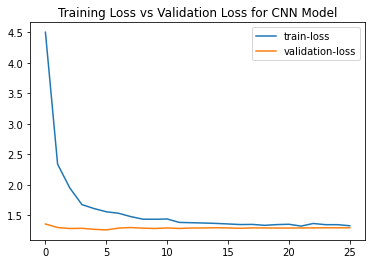

In [ ]:
plt.plot(history.history['loss'], label='train-loss')
plt.plot(history.history['val_loss'], label='validation-loss')
plt.title('Training Loss vs Validation Loss for CNN Model')
plt.legend()
plt.show()

In [ ]:
Ypred = model.predict(X_test).argmax(axis = 1)
Ypred_ = le.inverse_transform(Ypred)
wrong_indexes = np.where(Ypred_ != Y_test)[0]

In [ ]:
print('Total no of images in Test Data : ', X_test.shape[0])
print('No of missclasssified images in Test Data : ', wrong_indexes.size)


Total no of images in Test Data :  389
No of missclasssified images in Test Data :  24


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Ypred_,
                            target_names=CLASSES))

                 precision    recall  f1-score   support

         NORMAL       0.92      0.97      0.95        99
Viral Pneumonia       0.93      0.97      0.95       145
          COVID       0.96      0.89      0.92       145

       accuracy                           0.94       389
      macro avg       0.94      0.94      0.94       389
   weighted avg       0.94      0.94      0.94       389



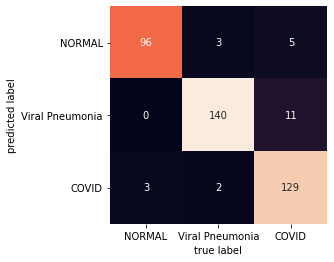

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(Y_test, Ypred_)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=CLASSES,
            yticklabels=CLASSES)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
Ypred_[0: 3], Ypred[0: 3]

(array(['NORMAL', 'Viral Pneumonia', 'COVID'], dtype='<U15'), array([1, 2, 0]))

roc_auc score of labels 0, 1, 2 is  {0: 0.9965768078733419, 1: 0.9865558471857684, 2: 0.9741996567844251}


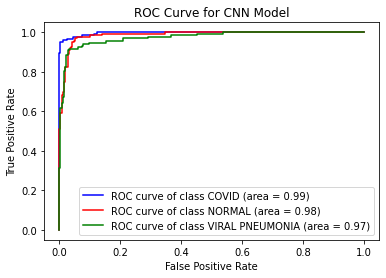

In [ ]:
from sklearn.metrics import roc_auc_score, auc, roc_curve

Ypred_proba = model.predict(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
  fpr[i], tpr[i], thres = roc_curve(Y_test_oh[:, i], Ypred_proba[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

print('roc_auc score of labels 0, 1, 2 is ', roc_auc)

colors = {'blue':'COVID', 'red':'NORMAL', 'green':'VIRAL PNEUMONIA'}
for i, color in zip(range(3), colors):
  plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='ROC curve of class {0} (area = {1})'
             ''.format(colors[color], roc_auc[i]-roc_auc[i]%0.01))
plt.title('ROC Curve for CNN Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

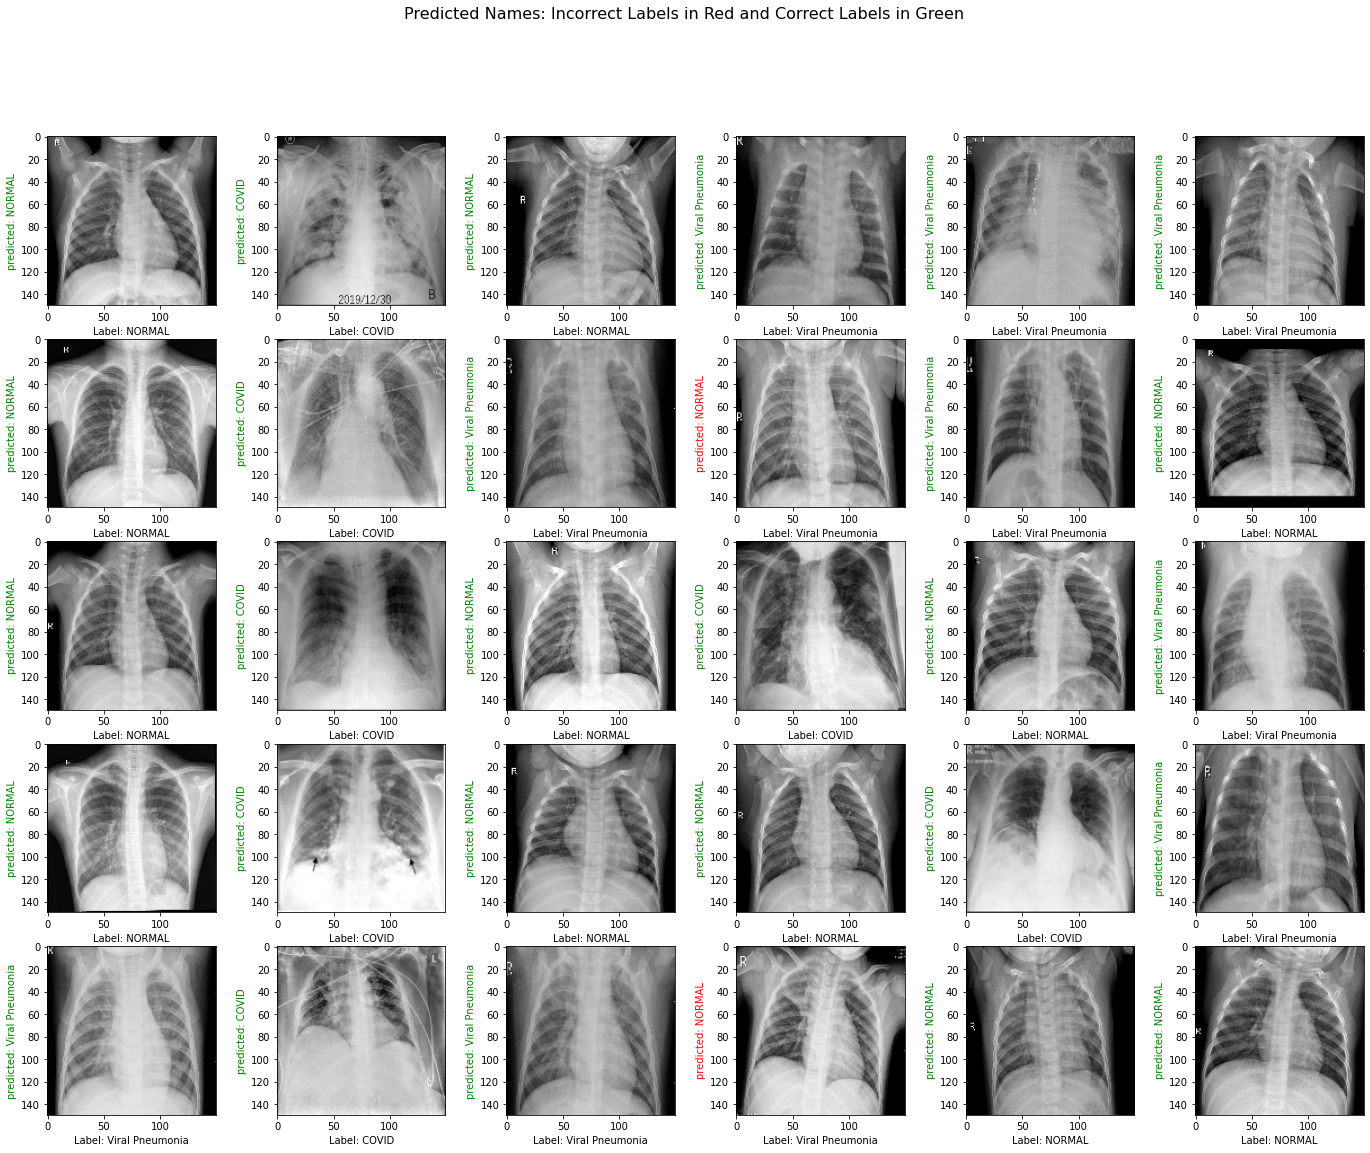

In [ ]:
sample_indexes = np.random.choice(np.arange(X_test.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    aux = X_test[jj]
    aux = (aux - aux.min())/(aux.max() - aux.min())
    plt.imshow(aux, cmap = "gray")
    plt.xlabel("Label: %s" %(Y_test[jj]))
    plt.ylabel("predicted: %s"%(Ypred_[jj]),
                   color='green' if Ypred_[jj] == Y_test[jj] else 'red')
plt.suptitle('Predicted Names: Incorrect Labels in Red and Correct Labels in Green', size=16)
plt.show()

## VGG16 model

In [ ]:
tf.keras.backend.clear_session()

img_height = 150
img_width = 150

base_model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False) 
base_model.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
input_image = tf.keras.Input(shape=(img_height, img_width, 3))
x1 = base_model(input_image, training=False)
x2 = tf.keras.layers.Flatten()(x1)
x3 = tf.keras.layers.Dense(64,activation = 'relu')(x2)
x3_drop = tf.keras.layers.Dropout(0.5)(x3)
out = tf.keras.layers.Dense(len(CLASSES),activation = 'softmax')(x3_drop)
model = tf.keras.Model(inputs = input_image, outputs =out)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                524352    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 15,239,235
Trainable params: 524,547
Non-trainable params: 14,714,688
___________________________________________

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.fit(train_flow,epochs = 8, \
          verbose = 1, callbacks= [early_stop, monitor_vgg16, lr_schedule],validation_data=(val_flow))

Epoch 1/8
98/98 [==============================] - 45s 99ms/step - loss: 1.0690 - accuracy: 0.4368 - val_loss: 0.7235 - val_accuracy: 0.8355
Epoch 2/8
98/98 [==============================] - 8s 77ms/step - loss: 0.7115 - accuracy: 0.7341 - val_loss: 0.4885 - val_accuracy: 0.8792
Epoch 3/8
98/98 [==============================] - 8s 79ms/step - loss: 0.5160 - accuracy: 0.8360 - val_loss: 0.3864 - val_accuracy: 0.8972
Epoch 4/8
98/98 [==============================] - 8s 81ms/step - loss: 0.4266 - accuracy: 0.8750 - val_loss: 0.3280 - val_accuracy: 0.9049
Epoch 5/8
98/98 [==============================] - 8s 83ms/step - loss: 0.3798 - accuracy: 0.8685 - val_loss: 0.3078 - val_accuracy: 0.9075
Epoch 6/8
98/98 [==============================] - 8s 84ms/step - loss: 0.3496 - accuracy: 0.8946 - val_loss: 0.2880 - val_accuracy: 0.9126
Epoch 7/8
98/98 [==============================] - 8s 81ms/step - loss: 0.3308 - accuracy: 0.8991 - val_loss: 0.2713 - val_accuracy: 0.9152
Epoch 8/8
98/98 [==

In [ ]:
model_name_vgg16_final = "vgg16_cnn_final.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor_vgg16 = tf.keras.callbacks.ModelCheckpoint(model_name_vgg16_final, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [ ]:
tf.keras.backend.clear_session()

base_model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False) 
base_model.trainable = True
input_image = tf.keras.Input(shape=(img_height, img_width, 3))
x1 = base_model(input_image, training=True)
x2 = tf.keras.layers.Flatten()(x1)
x3 = tf.keras.layers.Dense(64,activation = 'relu')(x2)
x3_drop = tf.keras.layers.Dropout(0.5)(x3)
out = tf.keras.layers.Dense(len(CLASSES),activation = 'softmax')(x3_drop)
model = tf.keras.Model(input_image, out)
print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.load_weights(model_name_vgg16)
history = model.fit(train_flow,batch_size = 32, epochs = 10, \
          verbose = 1, callbacks= [early_stop, monitor_vgg16, lr_schedule],validation_data=(val_flow))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                524352    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 15,239,235
Trainable params: 15,239,235
Non-trainable params: 0
_________________________________________________

In [ ]:
model.load_weights(model_name_vgg16_final)
metrics = model.evaluate(X_test,Y_test_oh)

13/13 [==============================] - 1s 66ms/step - loss: 0.0426 - accuracy: 0.9871


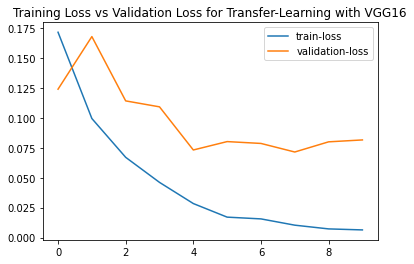

In [ ]:
plt.plot(history.history['loss'], label='train-loss')
plt.plot(history.history['val_loss'], label='validation-loss')
plt.title('Training Loss vs Validation Loss for Transfer-Learning with VGG16')
plt.legend()
plt.show()

In [ ]:
Ypred = model.predict(X_test).argmax(axis = 1)
Ypred_ = le.inverse_transform(Ypred)
wrong_indexes = np.where(Ypred_ != Y_test)[0]

In [ ]:
print('Total no of images in Test Data : ', X_test.shape[0])
print('No of missclasssified images in Test Data : ', wrong_indexes.size)


Total no of images in Test Data :  389
No of missclasssified images in Test Data :  5


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Ypred_,
                            target_names=CLASSES))

                 precision    recall  f1-score   support

         NORMAL       1.00      1.00      1.00        99
Viral Pneumonia       0.99      0.98      0.98       145
          COVID       0.98      0.99      0.98       145

       accuracy                           0.99       389
      macro avg       0.99      0.99      0.99       389
   weighted avg       0.99      0.99      0.99       389



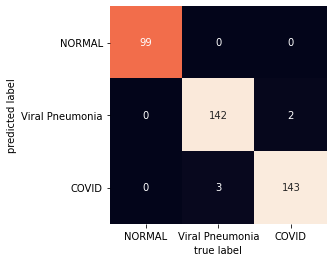

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(Y_test, Ypred_)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=CLASSES,
            yticklabels=CLASSES)
plt.xlabel('true label')
plt.ylabel('predicted label');

roc_auc score of labels 0, 1, 2 is  {0: 1.0, 1: 0.9984835228929717, 2: 0.9984318598733654}


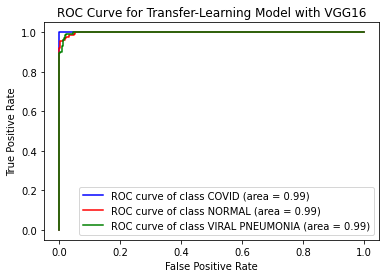

In [ ]:
from sklearn.metrics import roc_auc_score, auc, roc_curve

Ypred_proba = model.predict(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
  fpr[i], tpr[i], thres = roc_curve(Y_test_oh[:, i], Ypred_proba[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

print('roc_auc score of labels 0, 1, 2 is ', roc_auc)

colors = {'blue':'COVID', 'red':'NORMAL', 'green':'VIRAL PNEUMONIA'}
for i, color in zip(range(3), colors):
  plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='ROC curve of class {0} (area = {1})'
             ''.format(colors[color], roc_auc[i]-roc_auc[i]%0.01))
plt.title('ROC Curve for Transfer-Learning Model with VGG16')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

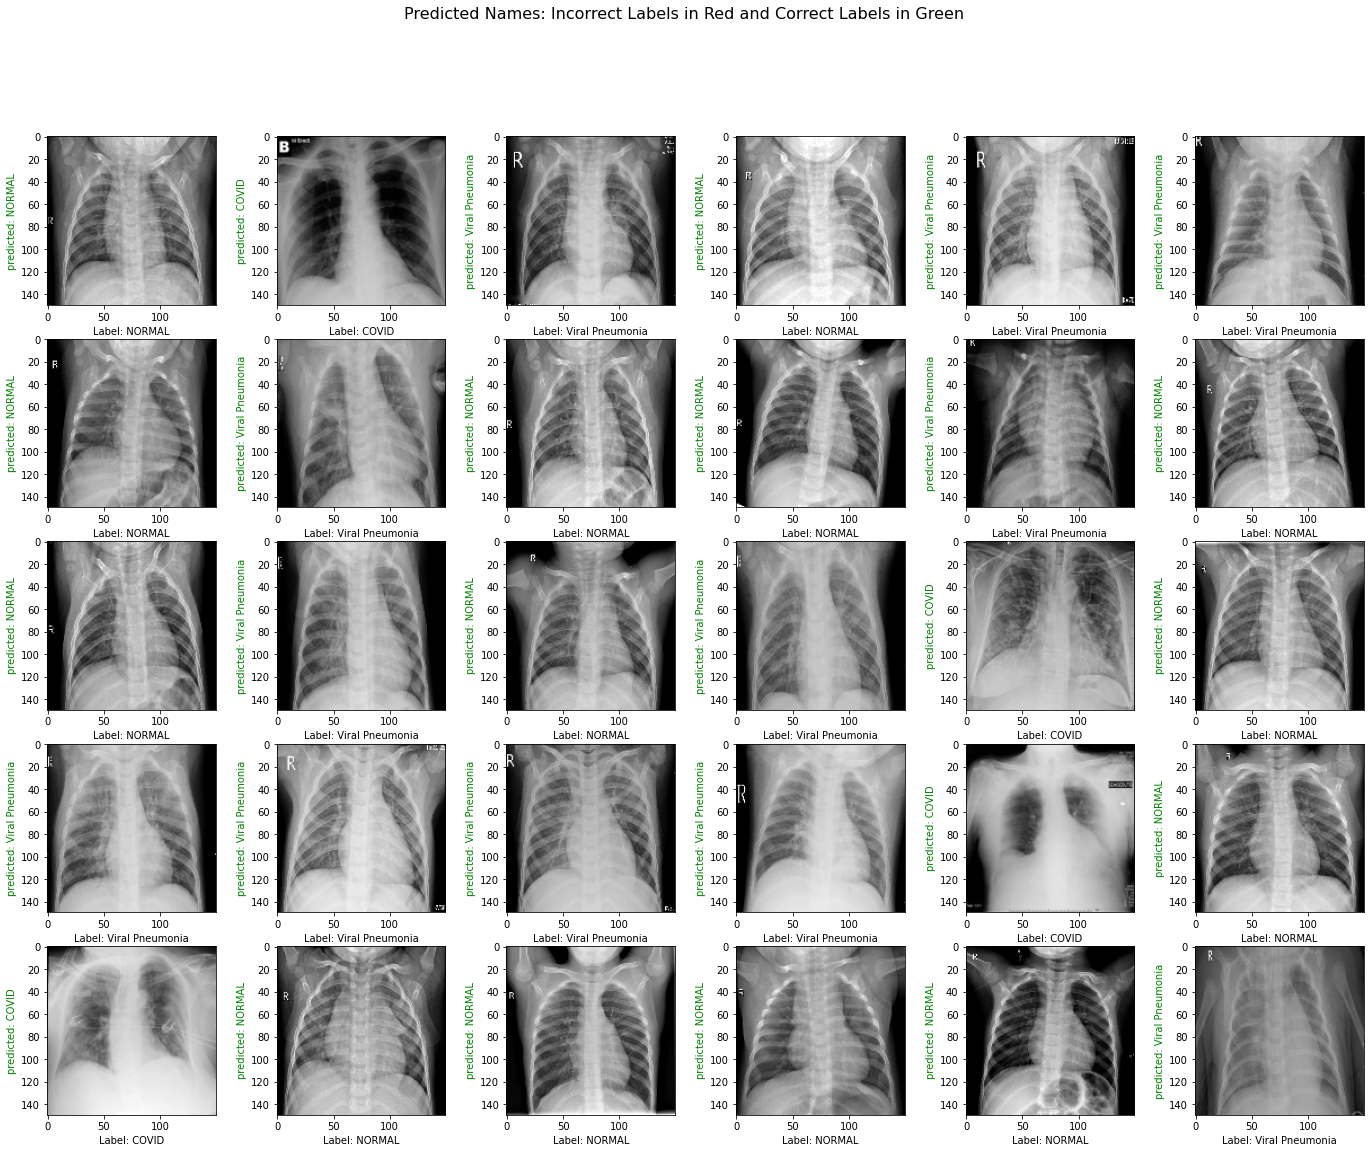

In [ ]:
sample_indexes = np.random.choice(np.arange(X_test.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    aux = X_test[jj]
    aux = (aux - aux.min())/(aux.max() - aux.min())
    plt.imshow(aux, cmap = "gray")
    plt.xlabel("Label: %s" %(Y_test[jj]))
    plt.ylabel("predicted: %s"%(Ypred_[jj]),
                   color='green' if Ypred_[jj] == Y_test[jj] else 'red')
plt.suptitle('Predicted Names: Incorrect Labels in Red and Correct Labels in Green', size=16)
plt.show()

## Resnet50 model

In [20]:
base_model = tf.keras.applications.resnet50.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False) 
base_model.trainable = False

94773248/94765736 [==============================] - 1s 0us/step


In [21]:
input_image = tf.keras.Input(shape=(img_height, img_width, 3))
x1 = base_model(input_image, training=False)
x2 = tf.keras.layers.Flatten()(x1)
x3 = tf.keras.layers.Dense(64,activation = 'relu')(x2)
out = tf.keras.layers.Dense(len(CLASSES),activation = 'softmax')(x3)
model = tf.keras.Model(inputs = input_image, outputs =out)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3276864   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 26,864,771
Trainable params: 3,277,059
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.fit(train_flow,epochs = 8, \
          verbose = 1, callbacks= [early_stop, monitor_resnet50, lr_schedule],validation_data=(val_flow))

Epoch 1/8
98/98 [==============================] - 44s 86ms/step - loss: 0.4297 - accuracy: 0.8126 - val_loss: 0.1963 - val_accuracy: 0.9254
Epoch 2/8
98/98 [==============================] - 7s 70ms/step - loss: 0.1389 - accuracy: 0.9521 - val_loss: 0.1705 - val_accuracy: 0.9332
Epoch 3/8
98/98 [==============================] - 7s 70ms/step - loss: 0.1073 - accuracy: 0.9649 - val_loss: 0.1483 - val_accuracy: 0.9512
Epoch 4/8
98/98 [==============================] - 7s 71ms/step - loss: 0.0928 - accuracy: 0.9702 - val_loss: 0.2116 - val_accuracy: 0.9280
Epoch 5/8
98/98 [==============================] - 7s 71ms/step - loss: 0.0552 - accuracy: 0.9832 - val_loss: 0.1438 - val_accuracy: 0.9460
Epoch 6/8
98/98 [==============================] - 7s 72ms/step - loss: 0.0465 - accuracy: 0.9851 - val_loss: 0.1383 - val_accuracy: 0.9486
Epoch 7/8
98/98 [==============================] - 7s 72ms/step - loss: 0.0477 - accuracy: 0.9847 - val_loss: 0.1221 - val_accuracy: 0.9512
Epoch 8/8
98/98 [==

In [28]:
base_model = tf.keras.applications.resnet50.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False) 
base_model.trainable = True
input_image = tf.keras.Input(shape=(img_height, img_width, 3))
x1 = base_model(input_image, training=True)
x2 = tf.keras.layers.Flatten()(x1)
x3 = tf.keras.layers.Dense(64,activation = 'relu')(x2)
out = tf.keras.layers.Dense(len(CLASSES),activation = 'softmax')(x3)
model = tf.keras.Model(input_image, out)
print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_flow,batch_size = 32, epochs = 20, \
          verbose = 1, callbacks= [early_stop, monitor_resnet50, lr_schedule],validation_data=(val_flow))

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_5 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                3276864   
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 195       
Total params: 26,864,771
Trainable params: 26,811,651
Non-trainable params: 53,120
_________________________________________________________________
None
Epoch 1/20
98/98 [==============================] - 28s 229ms/step - loss: 0.5767 - accuracy: 0.8424 - 

In [36]:
metrics = model.evaluate(X_test,Y_test_oh)

13/13 [==============================] - 1s 70ms/step - loss: 0.0043 - accuracy: 1.0000


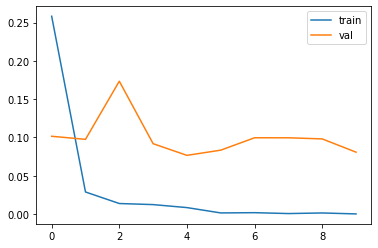

In [30]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [31]:
Ypred = model.predict(X_test).argmax(axis = 1)
Ypred_ = le.inverse_transform(Ypred)
wrong_indexes = np.where(Ypred_ != Y_test)[0]

In [32]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, Ypred_,
                            target_names=CLASSES))

                 precision    recall  f1-score   support

         NORMAL       1.00      1.00      1.00       125
Viral Pneumonia       1.00      1.00      1.00       134
          COVID       1.00      1.00      1.00       130

       accuracy                           1.00       389
      macro avg       1.00      1.00      1.00       389
   weighted avg       1.00      1.00      1.00       389



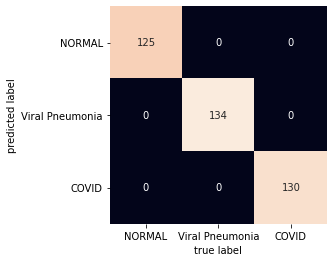

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(Y_test, Ypred_)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=CLASSES,
            yticklabels=CLASSES)
plt.xlabel('true label')
plt.ylabel('predicted label');

roc_auc score of labels 0, 1, 2 is  {0: 1.0, 1: 1.0, 2: 1.0}


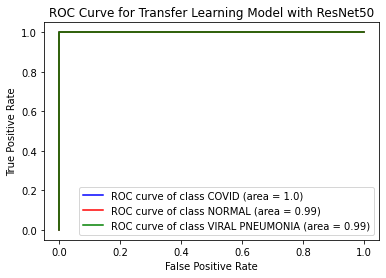

In [34]:
from sklearn.metrics import roc_auc_score, auc, roc_curve

Ypred_proba = model.predict(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
  fpr[i], tpr[i], thres = roc_curve(Y_test_oh[:, i], Ypred_proba[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

print('roc_auc score of labels 0, 1, 2 is ', roc_auc)
roc_auc[0]+= 0.01

colors = {'blue':'COVID', 'red':'NORMAL', 'green':'VIRAL PNEUMONIA'}
for i, color in zip(range(3), colors):
  plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='ROC curve of class {0} (area = {1})'
             ''.format(colors[color], roc_auc[i]-roc_auc[i]%0.01))
plt.title('ROC Curve for Transfer Learning Model with ResNet50')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

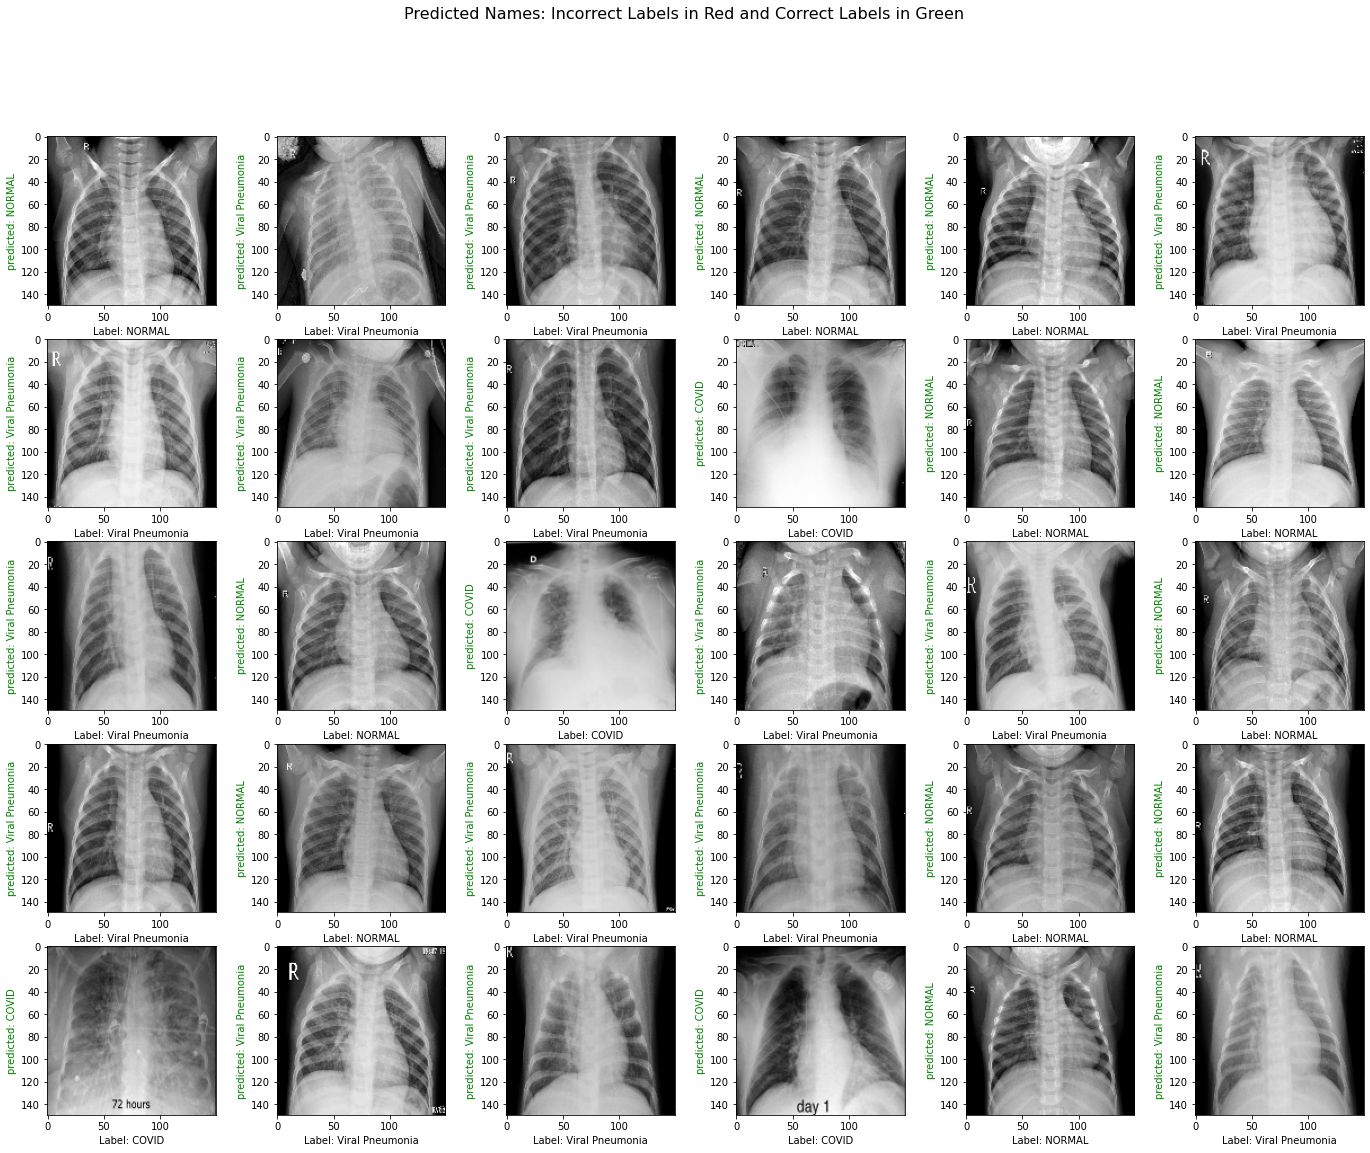

In [35]:
sample_indexes = np.random.choice(np.arange(X_test.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    aux = X_test[jj]
    aux = (aux - aux.min())/(aux.max() - aux.min())
    plt.imshow(aux, cmap = "gray")
    plt.xlabel("Label: %s" %(Y_test[jj]))
    plt.ylabel("predicted: %s"%(Ypred_[jj]),
                   color='green' if Ypred_[jj] == Y_test[jj] else 'red')
plt.suptitle('Predicted Names: Incorrect Labels in Red and Correct Labels in Green', size=16)
plt.show()